In [15]:
#dependencies
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
print('loading data...')
data1 = pd.read_csv('../../data/train_month_1.csv',parse_dates = [29,30,32])
data2 = pd.read_csv('../../data/train_month_2.csv',parse_dates = [29,30,32])
data3 = pd.read_csv('../../data/train_month_3_with_target.csv',parse_dates = [29,30,32])
print('data loaded...')


constant_all = []
for col in data1.columns:
    if data1[col].equals(data2[col]) & data2[col].equals(data3[col]):
        constant_all.append(col)

print('-'*65)
print('Features that are constant across the three previous months (in sample):')
print(constant_all)
print('-'*65)

def type_caster_and_transformer(data, time):
    """
    Casting to appropriate data types, dropping columns that are constant over time 
    """
    
    # convert bool
    cols_binary = ['homebanking_active', 'has_homebanking',
       'has_insurance_21', 'has_insurance_23', 'has_life_insurance_fixed_cap',
       'has_life_insurance_decreasing_cap', 'has_fire_car_other_insurance',
       'has_personal_loan', 'has_mortgage_loan', 'has_current_account',
       'has_pension_saving', 'has_savings_account',
       'has_savings_account_starter', 'has_current_account_starter','customer_self_employed']
    data[cols_binary] = data[cols_binary].astype('bool')
    if 'target' in data.columns:
        data['target'] = data['target'].astype('bool')
        
    # convert objects
    cols_object = ['customer_occupation_code', 'customer_postal_code', 'customer_education', 
                   'customer_children','customer_relationship','customer_gender']
    data[cols_object] = data[cols_object].astype('object')

    
    # these should be constant in the last three month
    cols_drop = ['customer_since_all','customer_since_bank'
                 ,'customer_gender','customer_birth_date']
    data.drop(columns = cols_drop, inplace = True)
    
    # add time 
    data['month'] = int(time)
    return data

type_caster_and_transformer(data1,(-2)); 
type_caster_and_transformer(data2,(-1))
type_caster_and_transformer(data3,(0))

data1 = pd.concat([data1,data3.target],axis = 1)
data2 =pd.concat([data2,data3.target],axis = 1)

loading data...
data loaded...
-----------------------------------------------------------------
Features that are constant across the three previous months (in sample):
['client_id', 'customer_since_all', 'customer_since_bank', 'customer_gender', 'customer_birth_date', 'customer_postal_code', 'customer_occupation_code', 'customer_education']
-----------------------------------------------------------------


In [3]:
data = pd.concat([data1,data2,data3],ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191091 entries, 0 to 191090
Data columns (total 37 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   client_id                          191091 non-null  object 
 1   homebanking_active                 191091 non-null  bool   
 2   has_homebanking                    191091 non-null  bool   
 3   has_insurance_21                   191091 non-null  bool   
 4   has_insurance_23                   191091 non-null  bool   
 5   has_life_insurance_fixed_cap       191091 non-null  bool   
 6   has_life_insurance_decreasing_cap  191091 non-null  bool   
 7   has_fire_car_other_insurance       191091 non-null  bool   
 8   has_personal_loan                  191091 non-null  bool   
 9   has_mortgage_loan                  191091 non-null  bool   
 10  has_current_account                191091 non-null  bool   
 11  has_pension_saving                 1910

<Figure size 432x288 with 0 Axes>

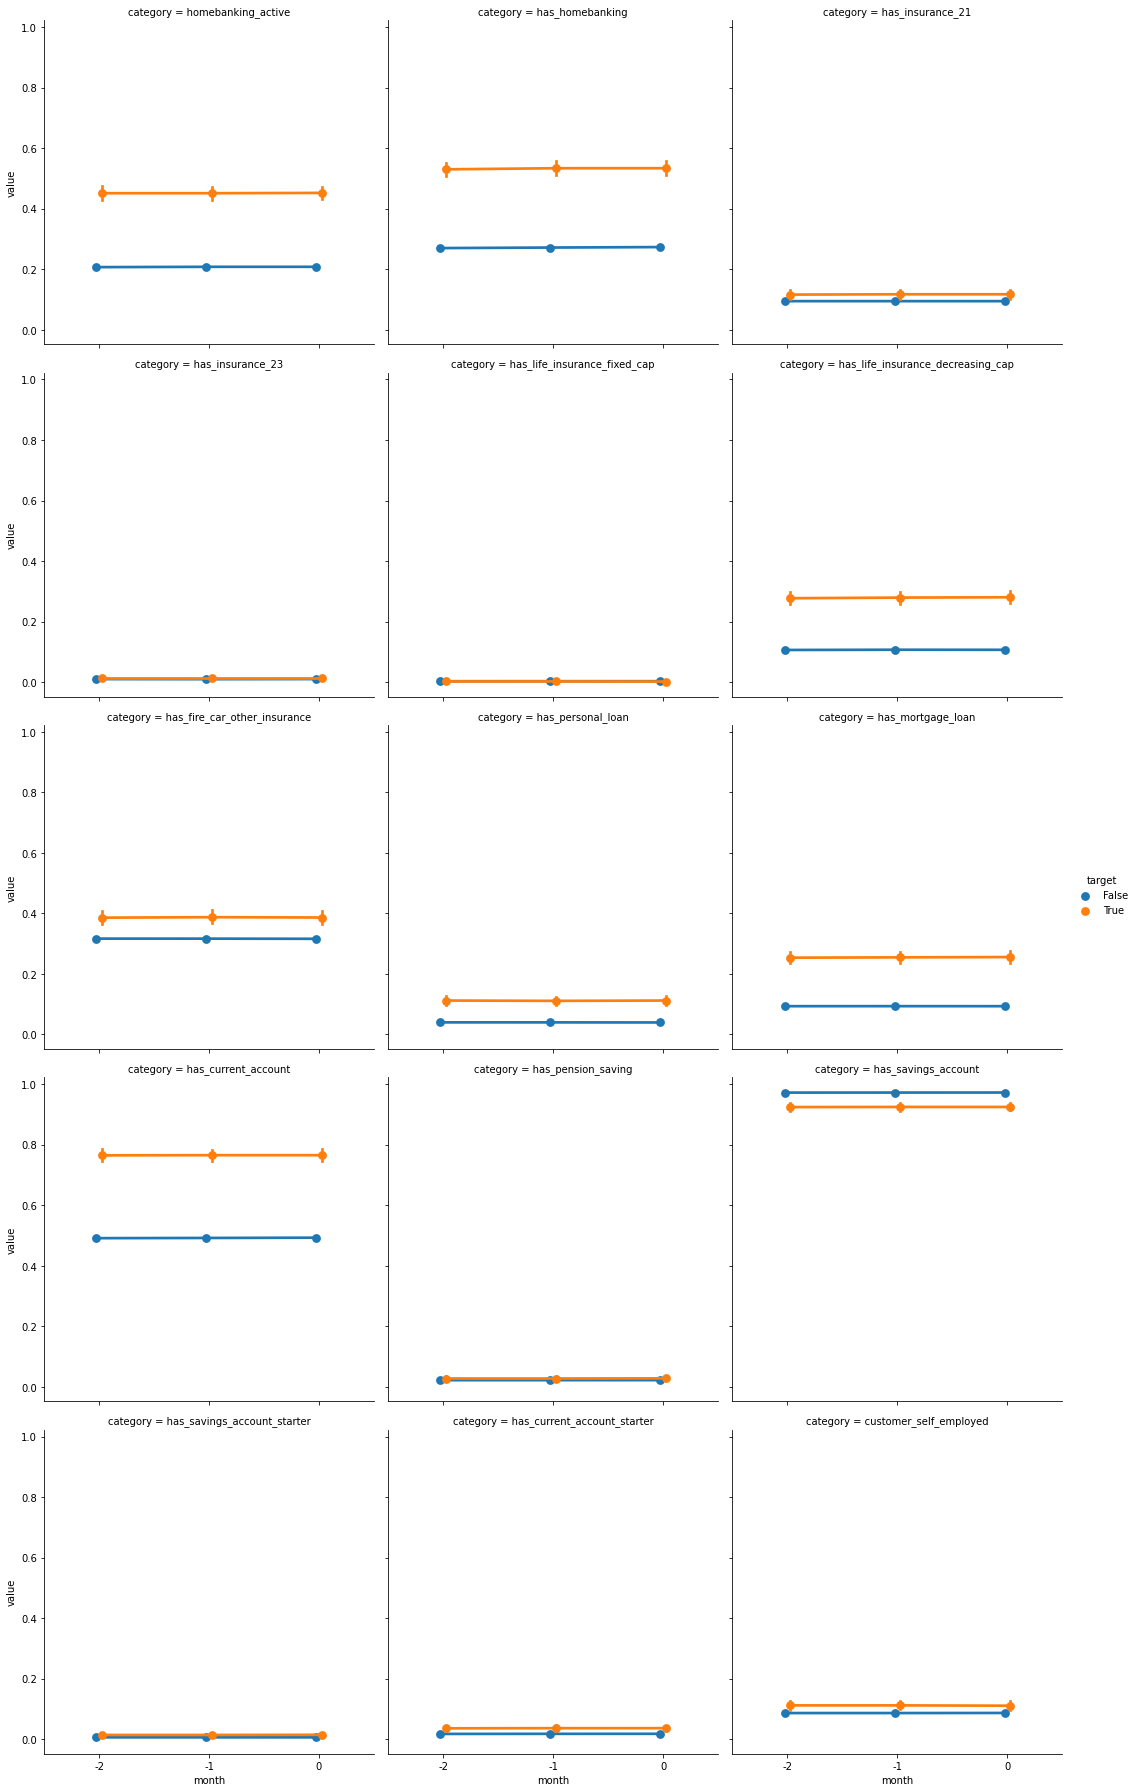

In [4]:
df_melt = data.melt(id_vars = ('client_id','month','target')
                  , value_vars = data.select_dtypes(include = 'bool').columns
                  , var_name='category'
                  , value_name="value")

plt.figure()
g = sns.catplot(data = df_melt
               , x = 'month'
               , y = 'value'
               , hue = 'target'
               , kind = 'point'
               , col = 'category'
               , col_wrap = 3
               , dodge = True)

<Figure size 432x288 with 0 Axes>

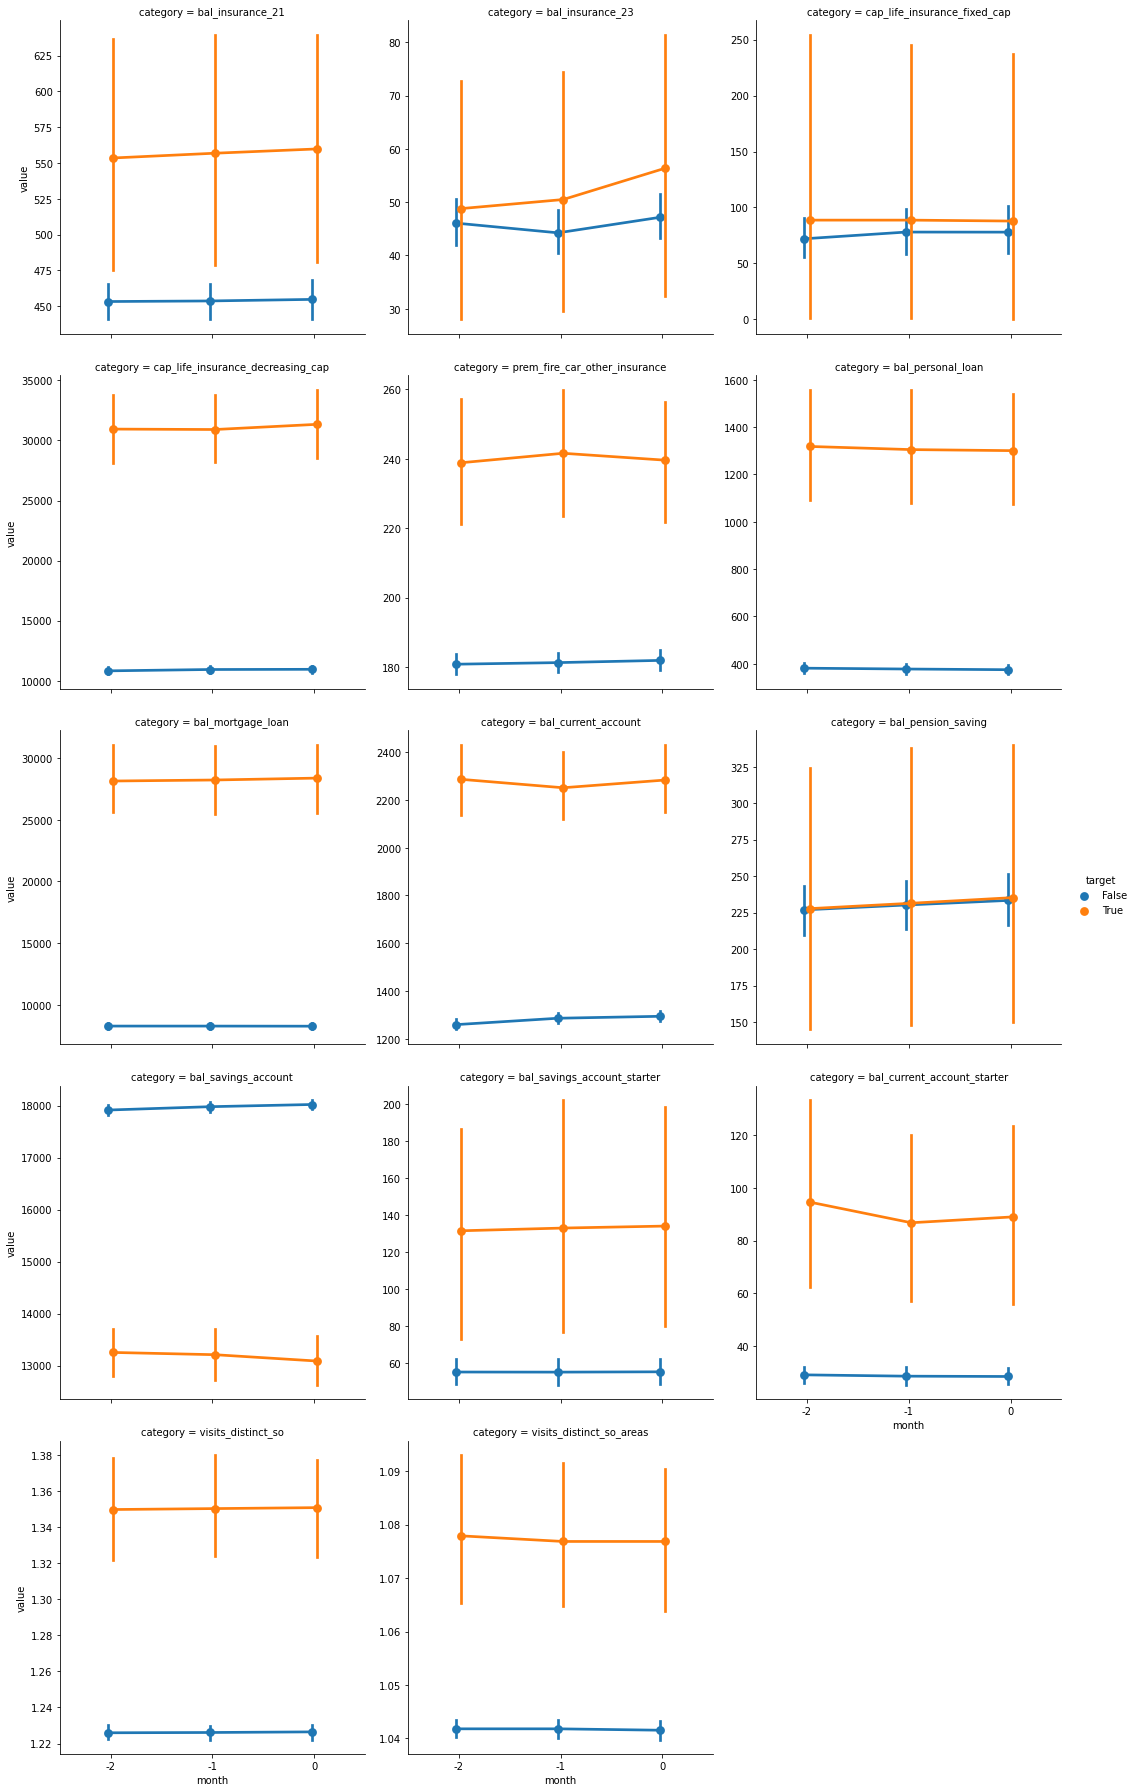

In [5]:
df_melt = data.melt(id_vars = ('client_id','month','target')
                  , value_vars = data.select_dtypes(include = 'number').columns
                  , var_name='category'
                  , value_name="value")

plt.figure()
g = sb.catplot(data = df_melt
               , x = 'month'
               , y = 'value'
               , hue = 'target'
               , kind = 'point'
               , col = 'category'
               , col_wrap = 3
               , sharey = False
               , dodge = True)

<Figure size 432x288 with 0 Axes>

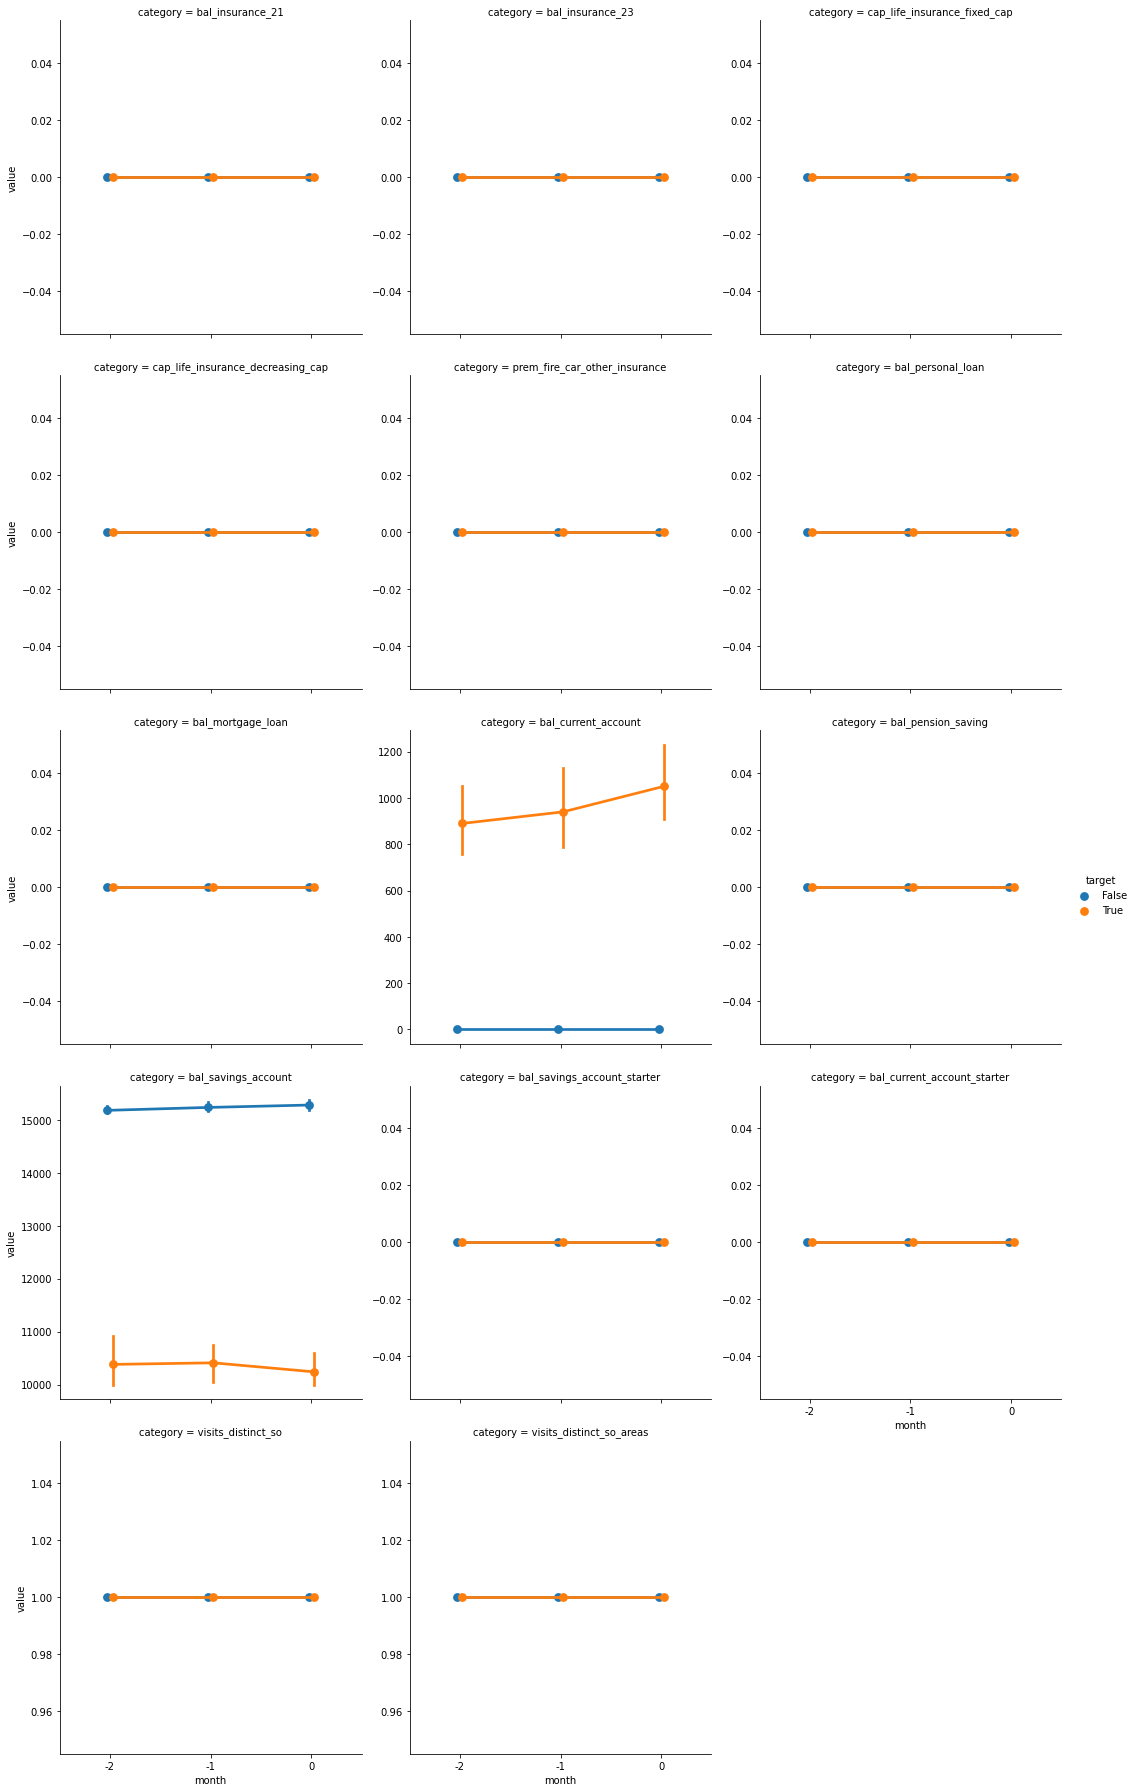

In [6]:
from numpy import median
        
df_melt = data.melt(id_vars = ('client_id','month','target')
                  , value_vars = data.select_dtypes(include = 'number').columns
                  , var_name='category'
                  , value_name="value")

plt.figure()
g = sns.catplot(data = df_melt
               , x = 'month'
               , y = 'value'
               , hue = 'target'
               , kind = 'point'
               , estimator = median
               , col = 'category'
               , col_wrap = 3
               , sharey = False
               , dodge = True)

## Investigate deltas

In [59]:
def delta(col,data1,data2,data3):

    delta1 = (data2[col].astype('int')-data1[col].astype('int'))
    delta2 = (data3[col].astype('int')-data2[col].astype('int'))
    delta3 = (data3[col].astype('int')-data1[col].astype('int'))

    data = pd.DataFrame({
        'client_id' : data1.client_id,
        'delta_1': delta1,
        'delta_2': delta2,
        'delta_3': delta3,
        'target':data3.target
    })
    
    return data

variables = ['bal_current_account', 'bal_savings_account','bal_insurance_23']

for var in variables:
    d = delta(var,data1,data2,data3)
    # display(d.head())
    # print('-'*20)
    print(var)
    print(d.corr().target[:-1])
    print('-'*20)

bal_current_account
delta_1   -0.014356
delta_2    0.005648
delta_3   -0.007014
Name: target, dtype: float64
--------------------
bal_savings_account
delta_1   -0.019400
delta_2   -0.030960
delta_3   -0.035209
Name: target, dtype: float64
--------------------
bal_insurance_23
delta_1    0.003737
delta_2    0.003209
delta_3    0.004941
Name: target, dtype: float64
--------------------


In [71]:
d = delta('bal_savings_account',data1,data2,data3)
print('check for colinearity')
print(d.delta_1.corr(data3.bal_savings_account))
print(d.delta_2.corr(data3.bal_savings_account))
print(d.delta_3.corr(data3.bal_savings_account))

check for colinearity
0.05106339481992979
0.05116528907734237
0.07186669833360639
